In [1]:
import sys
sys.path.append("..")

In [2]:
import utils
import mydatasets
import os
import numpy as np
import torch
import mymodels
from sklearn.manifold import TSNE
import ipywidgets as widgets
from ipywidgets import interact,fixed,interact_manual
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sb
import pandas as pd

In [3]:
DATASET="bibtex"
SPLIT=0
val_file_name="../runs/bibtex_datadict.p"

In [4]:
# change dirs because paths are hardcoded in mydatasets
curr_dir=os.getcwd()
os.chdir("..")
if DATASET in ["mediamill","delicious","bibtex"]:
    full_dataset,trn_splits,tst_splits=mydatasets.load_small_dataset(DATASET)
    trn_data,tst_data=mydatasets.get_small_dataset_split(full_dataset,trn_splits,tst_splits,SPLIT)
elif DATASET in ["eurlex"]:
    trn_data,tst_data=mydatasets.load_large_dataset(DATASET)
x_mat,y_mat,x_tst,y_tst=mydatasets.get_arrays(trn_data,tst_data)
# change back
os.chdir(curr_dir)

Loading datasets
../data/Bibtex/Bibtex_data.txt
../data/Bibtex/bibtex_trSplit.txt
../data/Bibtex/bibtex_tstSplit.txt
Number of splits : 10
## HEADER ##
#Point : 7395 , #Features : 1836 , #Labels : 159


In [5]:
label_counts=np.sum(y_mat,axis=0)
reorder=np.argsort(label_counts)
y_mat=y_mat[:,reorder]
num_points=x_mat.shape[0]
num_features=x_mat.shape[1]
num_labels=y_mat.shape[1]
print("----Training set stats----")
print("Number of points :",num_points)
print("Feature dimensionality :",num_features)
print("Label dimensionality :",num_labels)

----Training set stats----
Number of points : 4880
Feature dimensionality : 1836
Label dimensionality : 159


In [6]:
x_trn,y_trn,x_val,y_val=mydatasets.get_validation_split(x_mat,y_mat,val_file_name,None)

In [7]:
def trn_val_plot(model,myax,x_trn,x_val):
    emb_trn=model(torch.from_numpy(x_trn.astype('float32'))).detach().numpy()
    emb_val=model(torch.from_numpy(x_val.astype('float32'))).detach().numpy()
    emb_total=np.concatenate([emb_trn,emb_val],axis=0)
    x_tsne=TSNE(n_components=2,n_jobs=-1,metric="euclidean").fit_transform(emb_total)
    trn_val=["trn"]*emb_trn.shape[0] + ["val"]*emb_val.shape[0]
    df=pd.DataFrame(data={"x":x_tsne[:,0],"y":x_tsne[:,1],"trn/val":trn_val})
    _=sb.scatterplot(x="x",y="y",hue="trn/val",data=df,alpha=0.5,ax=myax)

### Training

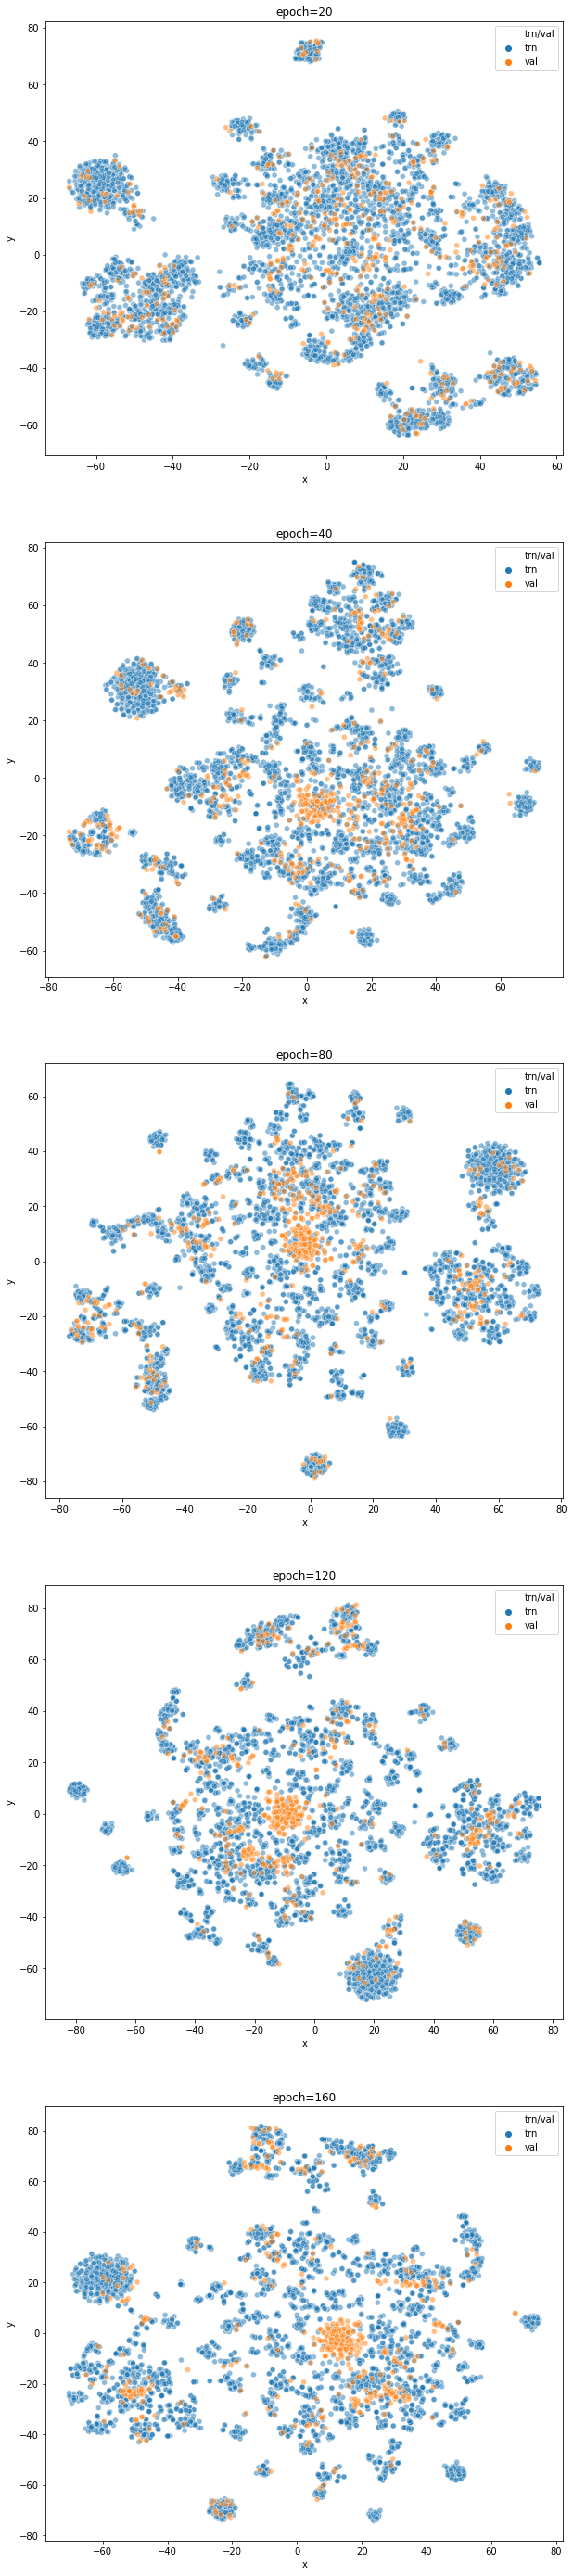

In [8]:
run="../runs/bibtex_40"
checkpoints=[20,40,80,120,160]
emb_dim=int(run.split("_")[-1])
n_rows=len(checkpoints)
fig,axes=plt.subplots(n_rows,1,squeeze=False,figsize=(10,10*n_rows))
for i,model_num in enumerate(checkpoints):
    model=torch.load(run+"/model_"+str(model_num))
    myax=axes[i][0]
    myax.set_title("epoch="+str(model_num))
    trn_val_plot(model,myax,x_trn,x_val)

* Large number of points from the validation set are mapped to a separate cluster - this is a clear indication of overfitting - even though validation performance improves (albeit marginally) in the training plots.

### Embedding dim

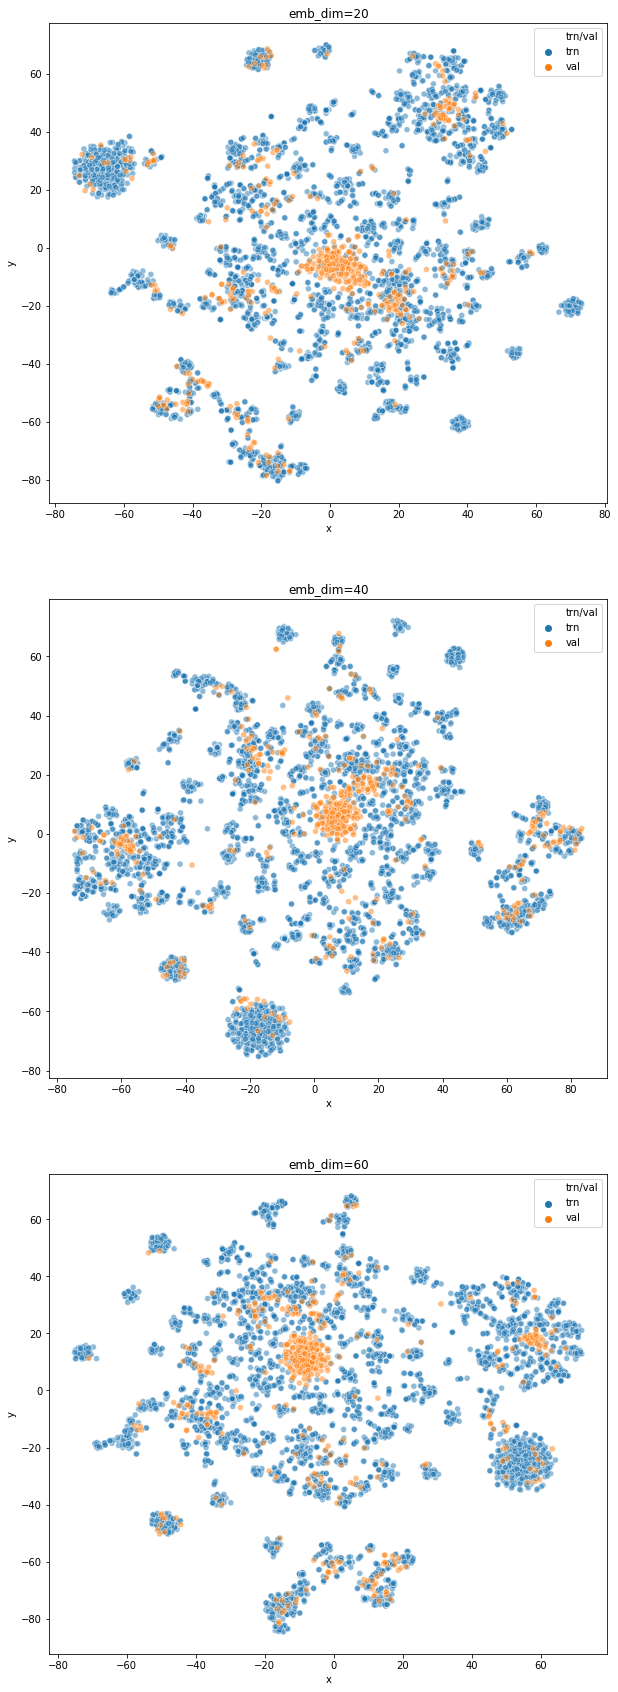

In [9]:
run_dirs=["../runs/bibtex_20","../runs/bibtex_40","../runs/bibtex_60"]
n_rows=len(run_dirs)
fig,axes=plt.subplots(n_rows,1,squeeze=False,figsize=(10,10*n_rows))
model_num=160
for i,run in enumerate(run_dirs):
    emb_dim=int(run.split("_")[-1])
    model=torch.load(run+"/model_"+str(model_num))
    myax=axes[i][0]
    myax.set_title("emb_dim="+str(emb_dim))
    trn_val_plot(model,myax,x_trn,x_val)

* It appears that a similar cluster structure appears for all values of embedding dimension, which is a desirable quality for the model.

### Margin

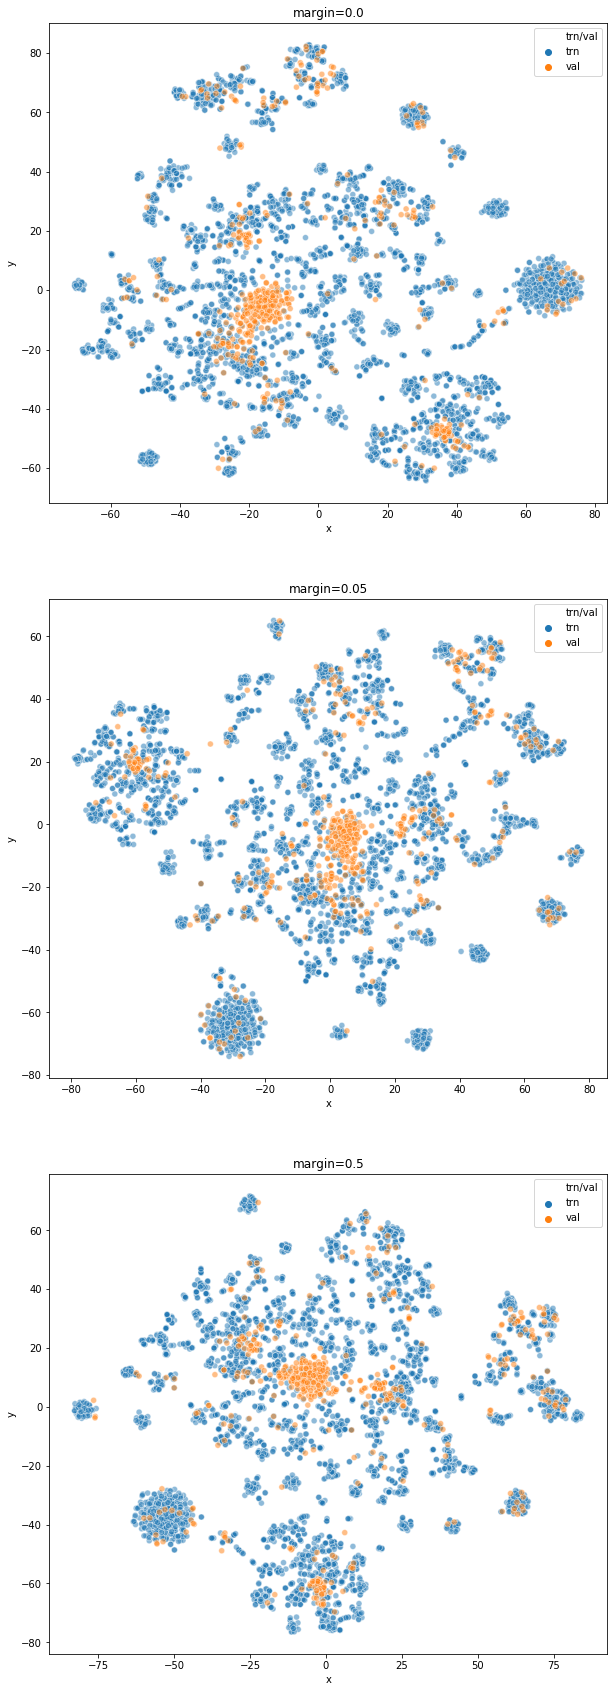

In [10]:
run_dirs=[(0.0,"../runs/bibtex_30"),(0.05,"../runs/bibtex_30_marg_0_05"),(0.5,"../runs/bibtex_30_marg_0_5")]
n_rows=len(run_dirs)
fig,axes=plt.subplots(n_rows,1,squeeze=False,figsize=(10,10*n_rows))
model_num=160
for i,run in enumerate(run_dirs):
    margin=run[0]
    model=torch.load(run[1]+"/model_"+str(model_num))
    myax=axes[i][0]
    myax.set_title("margin="+str(margin))
    trn_val_plot(model,myax,x_trn,x_val)

* It (arguably) looks like for margin=0.5, we have the most distinct clusters.

### Interactive visualization of labels

In [11]:
load_file_name="../runs/bibtex_40/model_40"

In [12]:
model=torch.load(load_file_name)
x_emb=model(torch.from_numpy(x_trn.astype('float32'))).detach().numpy()
x_tsne=TSNE(n_components=2,n_jobs=-1,metric="euclidean").fit_transform(x_emb)

In [13]:
def plot_labels_with_x_background(x_tsne,y_mat,lab_range):
    plt.figure(figsize=(10,10))
    sizes=[3 for j in range(0,x_tsne.shape[0])]
    plt.scatter(x_tsne[:,0],x_tsne[:,1],color="#eda6ae",s=sizes)
    supp_bool=np.sum(y_mat[:,lab_range[0]:lab_range[1]],axis=1)>0
    lab_points=x_tsne[supp_bool,:]
    plt.scatter(lab_points[:,0],lab_points[:,1],color="#43464a",marker="o")
    num_lab_points=np.sum(supp_bool)
    percent=np.round(100*num_lab_points/y_mat.shape[0],decimals=2)
    print("Number of points in label = ",num_lab_points,",",percent,"%")

In [14]:
label_selector=widgets.IntRangeSlider(
    value=[0,10],
    min=0,
    max=num_labels-1,
    step=1,
    description='Label Rank:',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='d'
)

In [15]:
_=interact_manual(plot_labels_with_x_background,x_tsne=fixed(x_tsne),y_mat=fixed(y_trn),lab_range=label_selector)

interactive(children=(IntRangeSlider(value=(0, 10), continuous_update=False, description='Label Rank:', max=15…

* It is clear that all the major clusters are formed by the larger labels.
* However, smaller labels have okay clustering.